In [1]:
import cv2
import numpy as np
from keras.models import load_model
import matplotlib.pyplot as plt

In [2]:
# Load your pre-trained binary classifier model
best_model = load_model('best_model.keras')

In [3]:
#Load YOLO
yolo_net = cv2.dnn.readNet('yolov3.weights', 'yolov3.cfg')  # Update paths as necessary
layer_names = yolo_net.getLayerNames()
output_layers = [layer_names[i - 1] for i in yolo_net.getUnconnectedOutLayers()]

In [4]:
image_path = input("Please enter the path to the image: ")
original_image = cv2.imread(image_path)

Please enter the path to the image:  /Users/tarunreddy/Desktop/images/both.webp


Image uploaded successfully: /Users/tarunreddy/Desktop/images/both.webp (Height: 400, Width: 600)


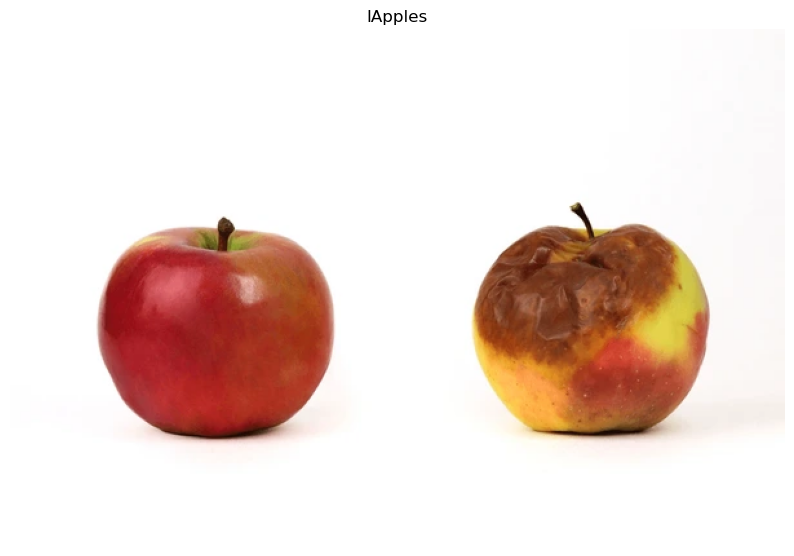

In [5]:
# Check if the image was loaded successfully
if original_image is not None:
    height, width = original_image.shape[:2]
    print(f"Image uploaded successfully: {image_path} (Height: {height}, Width: {width})")
    
    # Convert BGR to RGB for display
    original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    # Display the image using Matplotlib
    plt.figure(figsize=(10, 8))
    plt.imshow(original_image_rgb)
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.title('IApples')
    plt.show()
else:
    print("Failed to load the image. Please check the path.")

In [6]:
# Prepare the image for YOLO
blob = cv2.dnn.blobFromImage(original_image, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
yolo_net.setInput(blob)
outs = yolo_net.forward(output_layers)

In [7]:
# Process YOLO outputs to get bounding boxes for detected apples
boxes = []
confidences = []
class_ids = []
for out in outs:
    for detection in out:
        scores = detection[5:]  # Get class scores
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5:  # Confidence threshold
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            w = int(detection[2] * width)
            h = int(detection[3] * height)

            # Rectangle coordinates
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)

            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)


confidence_threshold = 0.5
nms_threshold = 0.6

In [8]:
indices = cv2.dnn.NMSBoxes(boxes, confidences, confidence_threshold, nms_threshold)

In [9]:
# Classify each detected apple
for i in indices:
    box = boxes[i]  # Directly use the index here
    x, y, w, h = box
    apple_image = original_image[y:y+h, x:x+w]  # Crop apple image

    # Resize for model input to (224, 224)
    model_input_width = 224  # Change to 224
    model_input_height = 224  # Change to 224
    apple_image_resized = cv2.resize(apple_image, (model_input_width, model_input_height))
    apple_image_normalized = apple_image_resized / 255.0  # Normalize
    apple_image_normalized = np.expand_dims(apple_image_normalized, axis=0)  # Add batch dimension

    # Make prediction
    prediction = best_model.predict(apple_image_normalized)

    # Check if the apple is rotten (assuming 1 = rotten, 0 = fresh)
    if prediction[0][0] > 0.5:  # Adjust threshold as needed
        cv2.rectangle(original_image, (x, y), (x + w, y + h), (0, 0, 255), 2)  # Draw red box for rotten apple
    else:
        cv2.rectangle(original_image, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Draw green box for fresh apple

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


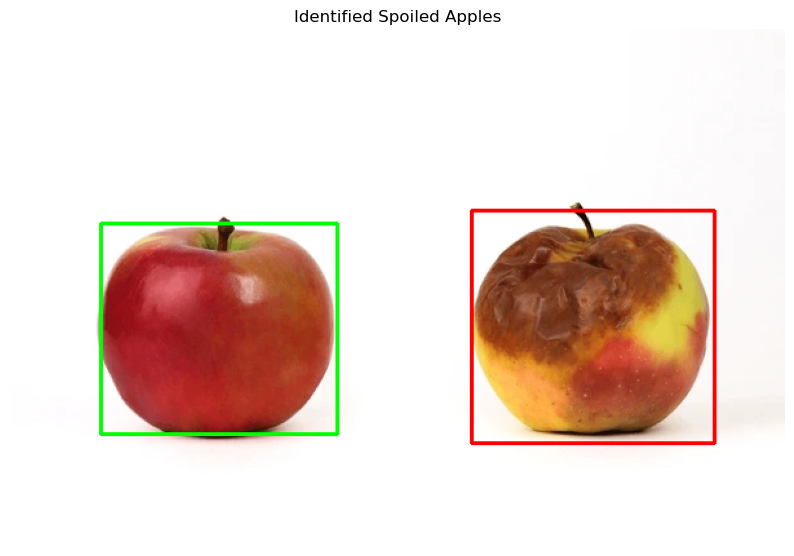

In [10]:
# Convert BGR to RGB
original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

# Display the image using Matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(original_image_rgb)
plt.axis('off')  # Turn off axis numbers and ticks
plt.title('Identified Spoiled Apples')
plt.show()